In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import os, sys

# Add to path the parent directory of this notebook dir

sys.path.append(os.path.dirname(os.getcwd()))
from view import plot_gamblers_value_function, plot_gamblers_policy
from policy_iteration import policy_evaluation_v, find_optimal_policy_q
from value_iteration import value_iteration_q, value_iteration_v_stochastic

In [11]:
import gymnasium as gym
import numpy as np
from typing import Tuple


class GamblersProblemEnv(gym.Env):
    """
    Gambler's Problem environment.
    """

    def __init__(self, goal_amount: int = 100, win_probability: float = 0.4):
        """
        Initialize the environment.

        Args:
            goal_amount (int): The goal capital amount to be achieved.
            win_probability (float): Probability of winning a bet.
        """
        self.goal_amount = goal_amount
        self.win_probability = win_probability

        # Action space: bet an amount from 0 to the current capital
        # Observation space: current capital amount
        self.action_space = gym.spaces.Discrete(goal_amount + 1)
        self.observation_space = gym.spaces.Discrete(goal_amount + 1)

        self.state = None
        self.reset()

    def step(self, action: int) -> Tuple[int, float, bool, dict]:
        """
        Execute one time step within the environment.

        Args:
            action (int): Amount of capital to bet.

        Returns:
            Tuple containing the new state, reward, done flag, and additional info.
        """
        assert self.action_space.contains(action), "Invalid action"

        done = False
        reward = 0

        # Win case
        if np.random.rand() < self.win_probability:
            self.state += action
            if self.state >= self.goal_amount:
                self.state = self.goal_amount
                reward = 1
                done = True
        else:
            # Lose case
            self.state -= action
            if self.state <= 0:
                self.state = 0
                done = True

        truncated = False
        return self.state, reward, done, truncated, {}

    def reset(self) -> int:
        """
        Reset the environment to an initial state.

        Returns:
            The initial state.
        """
        self.state = 1  # Start with capital of $1
        return self.state

    def render(self, mode="human"):
        """
        Render the environment.
        """
        if mode == "human":
            print(f"Current Capital: ${self.state}")
        elif mode == "ansi":
            return f"Current Capital: ${self.state}"
        else:
            raise NotImplementedError("Render mode not supported: " + mode)
        
    def build_mdp(self):
        """
        Build the MDP representation for the Gambler's Problem.
        """
        t_r_dict = {}

        for state in range(1, self.goal_amount):  # States from 1 to goal_amount - 1
            for action in range(1, min(state, self.goal_amount - state) + 1):  # Possible bets
                # Winning scenario
                win_state = min(state + action, self.goal_amount)
                win_reward = 1 if win_state == self.goal_amount else 0
                win_prob = self.win_probability

                # Losing scenario
                lose_state = max(state - action, 0)
                lose_reward = 0
                lose_prob = 1 - self.win_probability

                t_r_dict[(state, action)] = {
                    "win": (win_state, win_reward, win_state == self.goal_amount, win_prob),
                    "loss": (lose_state, lose_reward, lose_state == 0, lose_prob)
                }

        return t_r_dict


In [12]:
# Create an instance of the environment
env = GamblersProblemEnv(goal_amount=100, win_probability=0.4)

# Generate the MDP representation
t_r_dict = env.build_mdp()
t_r_dict

{(1, 1): {'win': (2, 0, False, 0.4), 'loss': (0, 0, True, 0.6)},
 (2, 1): {'win': (3, 0, False, 0.4), 'loss': (1, 0, False, 0.6)},
 (2, 2): {'win': (4, 0, False, 0.4), 'loss': (0, 0, True, 0.6)},
 (3, 1): {'win': (4, 0, False, 0.4), 'loss': (2, 0, False, 0.6)},
 (3, 2): {'win': (5, 0, False, 0.4), 'loss': (1, 0, False, 0.6)},
 (3, 3): {'win': (6, 0, False, 0.4), 'loss': (0, 0, True, 0.6)},
 (4, 1): {'win': (5, 0, False, 0.4), 'loss': (3, 0, False, 0.6)},
 (4, 2): {'win': (6, 0, False, 0.4), 'loss': (2, 0, False, 0.6)},
 (4, 3): {'win': (7, 0, False, 0.4), 'loss': (1, 0, False, 0.6)},
 (4, 4): {'win': (8, 0, False, 0.4), 'loss': (0, 0, True, 0.6)},
 (5, 1): {'win': (6, 0, False, 0.4), 'loss': (4, 0, False, 0.6)},
 (5, 2): {'win': (7, 0, False, 0.4), 'loss': (3, 0, False, 0.6)},
 (5, 3): {'win': (8, 0, False, 0.4), 'loss': (2, 0, False, 0.6)},
 (5, 4): {'win': (9, 0, False, 0.4), 'loss': (1, 0, False, 0.6)},
 (5, 5): {'win': (10, 0, False, 0.4), 'loss': (0, 0, True, 0.6)},
 (6, 1): {'win

Optimal Policy: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 12, 14: 14, 15: 15, 16: 16, 17: 8, 18: 18, 19: 6, 20: 20, 21: 21, 22: 3, 23: 23, 24: 1, 25: 25, 26: 24, 27: 23, 28: 22, 29: 21, 30: 30, 31: 19, 32: 18, 33: 17, 34: 16, 35: 15, 36: 14, 37: 13, 38: 12, 39: 39, 40: 10, 41: 41, 42: 8, 43: 7, 44: 6, 45: 5, 46: 4, 47: 3, 48: 2, 49: 1, 50: 50, 51: 49, 52: 48, 53: 47, 54: 46, 55: 45, 56: 44, 57: 43, 58: 42, 59: 41, 60: 40, 61: 39, 62: 38, 63: 37, 64: 36, 65: 35, 66: 34, 67: 33, 68: 32, 69: 31, 70: 30, 71: 29, 72: 28, 73: 27, 74: 26, 75: 25, 76: 24, 77: 23, 78: 22, 79: 21, 80: 20, 81: 19, 82: 18, 83: 17, 84: 16, 85: 15, 86: 14, 87: 13, 88: 12, 89: 11, 90: 10, 91: 9, 92: 8, 93: 7, 94: 6, 95: 5, 96: 4, 97: 3, 98: 2, 99: 1}
Value Function: {1: 0.0020656246423372466, 2: 0.005164061657483733, 3: 0.009225470507578229, 4: 0.012910154272810876, 5: 0.017385398178208892, 6: 0.02306367649958234, 7: 0.027814112109536528, 8: 0.03227538600478105, 9: 0.037685071

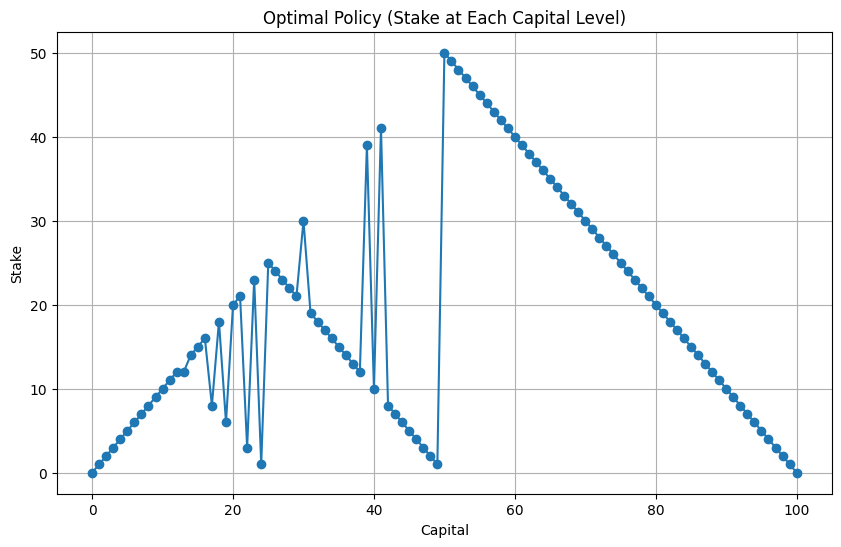

In [15]:
# Parameters for policy iteration
gamma = 1
theta = 1e-100

states = list(set([s for s, _ in t_r_dict.keys()]))
actions = list(set([a for _, a in t_r_dict.keys()]))

# Find the optimal policy using Q-value iteration
optimal_policy, optimal_value_function_v = value_iteration_v_stochastic(t_r_dict, states, actions, gamma=gamma, theta=theta)

print("Optimal Policy:", optimal_policy)
print("Value Function:", optimal_value_function_v)

plot_gamblers_policy(optimal_policy, max_capital=env.goal_amount)

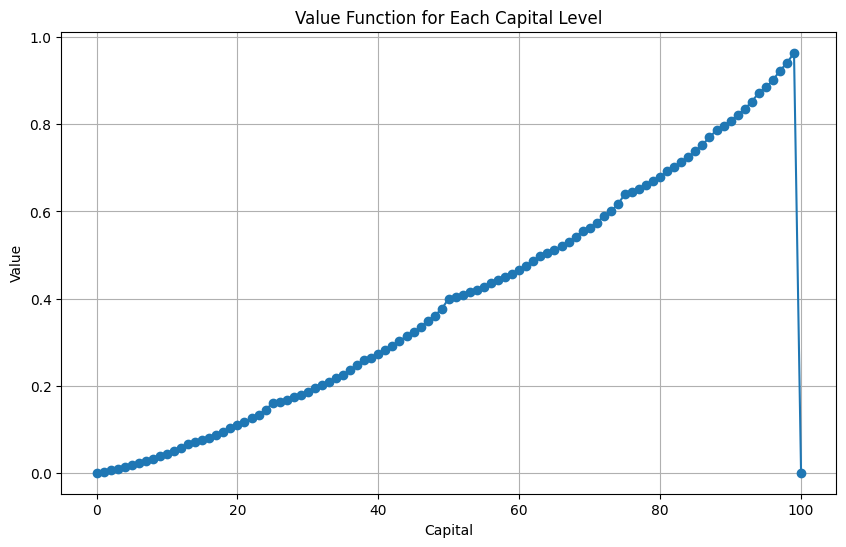

In [14]:
plot_gamblers_value_function(optimal_value_function_v, max_capital=env.goal_amount)